
# Multi-Criteria Analysis (MCA) Lab — Net-Zero 2050 Policy Options

This lab helps you explore how to evaluate policy pathways for achieving **net-zero emissions by 2050** using **Multi-Criteria Analysis (MCA)**.  
This notebook includes examples, weight visualization, and category-level analysis.

---

## Learning Goals
- Define decision alternatives and evaluation criteria
- Normalize heterogeneous indicators (0–100 scale)
- Apply different weighting strategies
- Create an aggregate index
- Visualize and interpret results
- Reflect on trade-offs and sensitivities

---


## 0) Setup — Install and import dependencies

In [1]:
!pip -q install pandas numpy matplotlib openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", 120)


## 1) Define alternatives and criteria

The pre-defined example compares four policy alternatives on multiple technical, economic, environmental, social, and institutional criteria.


In [2]:
# Input data 
raw_data = pd.DataFrame({
    "Alternative": [
        "NZ2050_DeepElec",
        "NZ2050_Balanced",
        "NPI_Current",
        "NZ2050_HydrogenPush"
    ],
    "Renewable_share_%": [85, 75, 55, 70],
    "Annual_storage_additions_GWh": [25, 18, 6, 22],
    "System_cost_pct_GDP": [4.2, 3.9, 3.2, 4.5],
    "Household_bill_EUR": [1200, 1300, 1500, 1250],
    "GHG_2050_MtCO2e": [30, 60, 220, 45],
    "Air_pollution_index": [20, 30, 60, 25],
    "Jobs_change_coal_regions_thousand": [+45, +30, -10, +25],
    "Energy_poverty_rate_%": [6, 7, 10, 8],
    "Implementation_readiness_score": [70, 65, 55, 68],
    "Regulatory_complexity_index": [30, 35, 50, 40],
    "Public_acceptance_index": [80, 70, 40, 60]
})

criterion_meta = pd.DataFrame({
    "criterion": [
        "Renewable_share_%",
        "Annual_storage_additions_GWh",
        "System_cost_pct_GDP",
        "Household_bill_EUR",
        "GHG_2050_MtCO2e",
        "Air_pollution_index",
        "Jobs_change_coal_regions_thousand",
        "Energy_poverty_rate_%",
        "Implementation_readiness_score",
        "Regulatory_complexity_index",
        "Public_acceptance_index"
    ],
    "direction": [
        "benefit", "benefit", "cost", "cost", "cost",
        "cost", "benefit", "cost", "benefit", "cost", "benefit"
    ],
    "Category": [
        "Technical", "Technical", "Economic", "Economic", "Environmental",
        "Environmental", "Social", "Social", "Institutional", "Institutional", "Social"
    ]
})


display(raw_data)
display(criterion_meta)


,Alternative,Renewable_share_%,Annual_storage_additions_GWh,System_cost_pct_GDP,Household_bill_EUR,GHG_2050_MtCO2e,Air_pollution_index,Jobs_change_coal_regions_thousand,Energy_poverty_rate_%,Implementation_readiness_score,Regulatory_complexity_index,Public_acceptance_index
0,NZ2050_DeepElec,85,25,4.2,1200,30,20,45,6,70,30,80
1,NZ2050_Balanced,75,18,3.9,1300,60,30,30,7,65,35,70
2,NPI_Current,55,6,3.2,1500,220,60,-10,10,55,50,40
3,NZ2050_HydrogenPush,70,22,4.5,1250,45,25,25,8,68,40,60


,criterion,direction,Category
0,Renewable_share_%,benefit,Technical
1,Annual_storage_additions_GWh,benefit,Technical
2,System_cost_pct_GDP,cost,Economic
3,Household_bill_EUR,cost,Economic
4,GHG_2050_MtCO2e,cost,Environmental
5,Air_pollution_index,cost,Environmental
6,Jobs_change_coal_regions_thousand,benefit,Social
7,Energy_poverty_rate_%,cost,Social
8,Implementation_readiness_score,benefit,Institutional
9,Regulatory_complexity_index,cost,Institutional


## 2) Normalization (0–100 scale)

In [3]:
def normalize_minmax(df_raw, meta):
    df = df_raw.copy()
    df_norm = pd.DataFrame({"Alternative": df["Alternative"]})
    for _, row in meta.iterrows():
        c = row["criterion"]
        direction = row["direction"].strip().lower()
        values = df[c].astype(float)
        cmin, cmax = values.min(), values.max()
        if np.isclose(cmax, cmin):
            df_norm[c] = 100.0
            continue
        if direction == "benefit":
            df_norm[c] = 100.0 * (values - cmin) / (cmax - cmin)
        elif direction == "cost":
            df_norm[c] = 100.0 * (cmax - values) / (cmax - cmin)
        else:
            raise ValueError(f"Unknown direction for {c}")
    return df_norm

normalized = normalize_minmax(raw_data, criterion_meta)
normalized

,Alternative,Renewable_share_%,Annual_storage_additions_GWh,System_cost_pct_GDP,Household_bill_EUR,GHG_2050_MtCO2e,Air_pollution_index,Jobs_change_coal_regions_thousand,Energy_poverty_rate_%,Implementation_readiness_score,Regulatory_complexity_index,Public_acceptance_index
0,NZ2050_DeepElec,100.000000,100.000000,23.076923,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.0,100.0
1,NZ2050_Balanced,66.666667,63.157895,46.153846,66.666667,84.210526,75.0,72.727273,75.0,66.666667,75.0,75.0
2,NPI_Current,0.000000,0.000000,100.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
3,NZ2050_HydrogenPush,50.000000,84.210526,0.000000,83.333333,92.105263,87.5,63.636364,50.0,86.666667,50.0,50.0


## 3) Weighting the criteria

In [4]:
direct_weights = {
    "Renewable_share_%": 0.08,
    "Annual_storage_additions_GWh": 0.07,
    "System_cost_pct_GDP": 0.12,
    "Household_bill_EUR": 0.08,
    "GHG_2050_MtCO2e": 0.25,
    "Air_pollution_index": 0.10,
    "Jobs_change_coal_regions_thousand": 0.10,
    "Energy_poverty_rate_%": 0.05,
    "Implementation_readiness_score": 0.05,
    "Regulatory_complexity_index": 0.03,
    "Public_acceptance_index": 0.07
}

crit_list = list(criterion_meta["criterion"])
w_direct = np.array([direct_weights[c] for c in crit_list])
w_sum = w_direct.sum()
if not np.isclose(w_sum, 1.0):
    w_direct /= w_sum

for c, w in zip(crit_list, w_direct):
    print(f"{c:35s} {w:.3f}")

Renewable_share_%                   0.080
Annual_storage_additions_GWh        0.070
System_cost_pct_GDP                 0.120
Household_bill_EUR                  0.080
GHG_2050_MtCO2e                     0.250
Air_pollution_index                 0.100
Jobs_change_coal_regions_thousand   0.100
Energy_poverty_rate_%               0.050
Implementation_readiness_score      0.050
Regulatory_complexity_index         0.030
Public_acceptance_index             0.070


### Visualize the weighting distribution

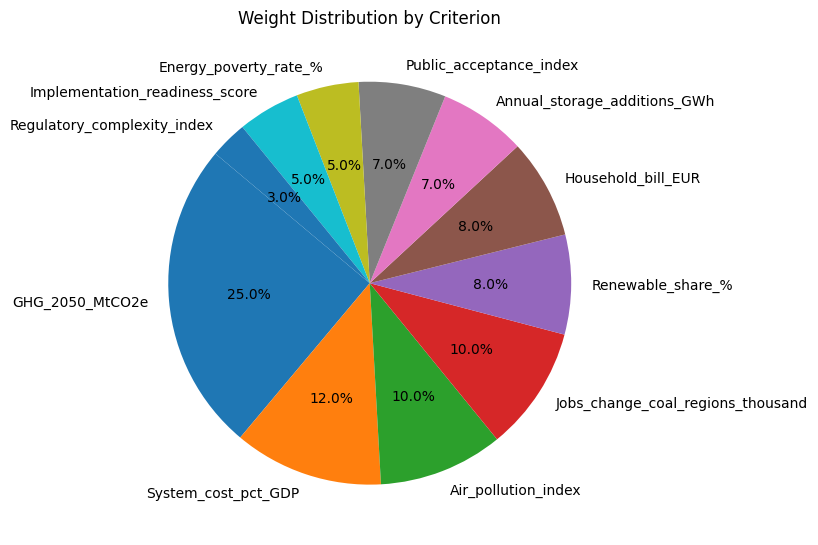

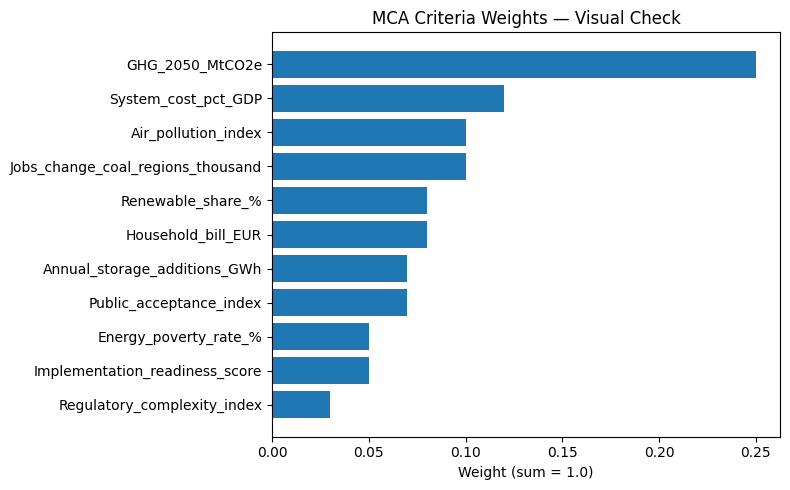

In [5]:
weights_df = pd.DataFrame({"Criterion": crit_list, "Weight": w_direct}).sort_values("Weight", ascending=False)

plt.figure(figsize=(8,8))
plt.pie(weights_df["Weight"], labels=weights_df["Criterion"], autopct="%1.1f%%", startangle=140)
plt.title("Weight Distribution by Criterion")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.barh(weights_df["Criterion"], weights_df["Weight"])
plt.xlabel("Weight (sum = 1.0)")
plt.title("MCA Criteria Weights — Visual Check")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Aggregate weights by category (pillar-level overview)

Weight share by category (pillar-level):


,Category,Weight
1,Environmental,0.35
3,Social,0.22
0,Economic,0.20
4,Technical,0.15
2,Institutional,0.08


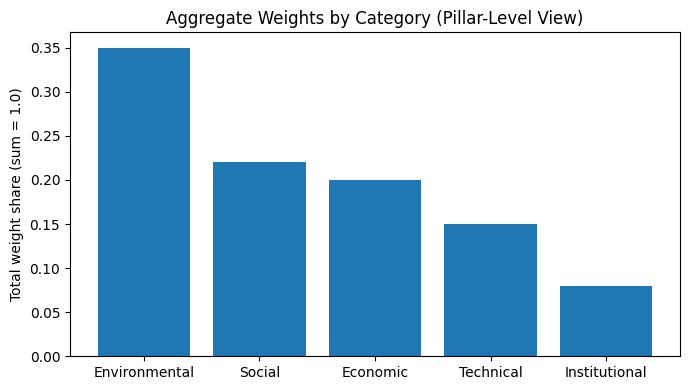

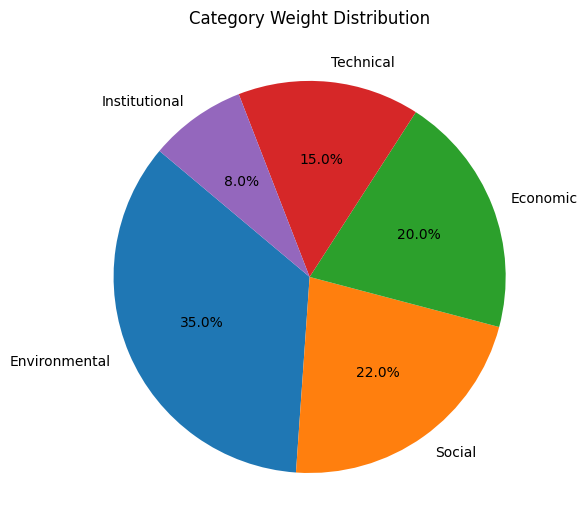

In [6]:
# Aggregate weights by category (Technical, Economic, Environmental, Social, Institutional)
cat_summary = criterion_meta.assign(Weight=w_direct).groupby("Category", as_index=False)["Weight"].sum().sort_values("Weight", ascending=False)

print("Weight share by category (pillar-level):")
display(cat_summary)

# --- Bar chart ---
plt.figure(figsize=(7, 4))
plt.bar(cat_summary["Category"], cat_summary["Weight"])
plt.title("Aggregate Weights by Category (Pillar-Level View)")
plt.ylabel("Total weight share (sum = 1.0)")
plt.tight_layout()
plt.show()

# --- Pie chart ---
plt.figure(figsize=(6, 6))
plt.pie(cat_summary["Weight"], labels=cat_summary["Category"], autopct="%1.1f%%", startangle=140)
plt.title("Category Weight Distribution")
plt.tight_layout()
plt.show()


## 4) Aggregate index — Weighted Sum

In [7]:
def aggregate_weighted_sum(df_norm, meta, w):
    crit = list(meta["criterion"])
    scores = df_norm[crit].values
    index = (scores * w).sum(axis=1)
    out = df_norm[["Alternative"]].copy()
    out["MCA_WeightedSum_0to100"] = index
    return out

agg_ws = aggregate_weighted_sum(normalized, criterion_meta, w_direct)
agg_ws.sort_values("MCA_WeightedSum_0to100", ascending=False)

,Alternative,MCA_WeightedSum_0to100
0,NZ2050_DeepElec,90.769231
1,NZ2050_Balanced,71.034873
3,NZ2050_HydrogenPush,66.534689
2,NPI_Current,12.000000



---

## Applying MCA at Different Levels: Scenarios vs. Technologies

Depending on your available data and the question you're addressing, you can apply this MCA framework in two complementary ways:

### **Path A — Scenario-Level Analysis**
Use this when comparing *integrated policy pathways* (e.g., "Net-Zero 2050", "Current Policies", "Hydrogen Push").
- Each alternative represents a **comprehensive scenario** from an energy system model.
- Criteria aggregate system-wide outcomes (emissions, cost, jobs, energy poverty, etc.).
- Useful for **policy recommendations** at the strategic level — e.g., “Which national pathway aligns best with net-zero and social goals?”
- Encourages cross-sector thinking, linking power, transport, industry, and buildings to reveal whole-economy trade-offs.

### **Path B — Technology-Level Analysis**
Use this when scenario outputs are too similar or when you want to explore **power-sector composition** in more detail.
- Alternatives represent **technologies** or **project options** (e.g., "Onshore Wind", "Solar PV", "Gas + CCS").
- Criteria describe performance, cost, environmental impact, land use, public acceptance, etc.
- Suitable for exploring **realism** and **trade-offs** in specific country contexts (e.g., Malta’s land constraints vs. solar potential).
- Enables granular decision-making on technology portfolios and diversification, identifying complementary roles of renewables, storage, and flexible generation.

> You may choose either or both approaches.
> The key is to maintain a transparent link between **quantitative model evidence** and **qualitative reasoning** (social, environmental, and institutional dimensions).



## 5) Comparing results under two different weight sets

To understand **how sensitive your MCA rankings are to stakeholder priorities**, you can test different sets of weights.

In this example, we compare:
- **Environmental Priority:** GHG and Air Pollution criteria get higher weights.
- **Economic Priority:** System cost and household bills are prioritized.

This helps visualize how the ranking of alternatives shifts when the emphasis changes.


In [8]:

# Define two different weighting schemes
weights_env_priority = {
    "Renewable_share_%": 0.08,
    "Annual_storage_additions_GWh": 0.06,
    "System_cost_pct_GDP": 0.05,
    "Household_bill_EUR": 0.05,
    "GHG_2050_MtCO2e": 0.35,
    "Air_pollution_index": 0.15,
    "Jobs_change_coal_regions_thousand": 0.07,
    "Energy_poverty_rate_%": 0.04,
    "Implementation_readiness_score": 0.07,
    "Regulatory_complexity_index": 0.03,
    "Public_acceptance_index": 0.05
}

weights_econ_priority = {
    "Renewable_share_%": 0.06,
    "Annual_storage_additions_GWh": 0.05,
    "System_cost_pct_GDP": 0.25,
    "Household_bill_EUR": 0.20,
    "GHG_2050_MtCO2e": 0.15,
    "Air_pollution_index": 0.05,
    "Jobs_change_coal_regions_thousand": 0.07,
    "Energy_poverty_rate_%": 0.05,
    "Implementation_readiness_score": 0.07,
    "Regulatory_complexity_index": 0.03,
    "Public_acceptance_index": 0.02
}

# Convert to aligned arrays
crit_list = list(criterion_meta["criterion"])
w_env = np.array([weights_env_priority[c] for c in crit_list])
w_econ = np.array([weights_econ_priority[c] for c in crit_list])

# Ensure normalization
w_env = w_env / w_env.sum()
w_econ = w_econ / w_econ.sum()

def aggregate_weighted_sum(df_norm, meta, w):
    crit = list(meta["criterion"])
    scores = df_norm[crit].values
    index = (scores * w).sum(axis=1)
    out = df_norm[["Alternative"]].copy()
    out["MCA_WeightedSum_0to100"] = index
    return out

# Aggregate results
agg_env = aggregate_weighted_sum(normalized, criterion_meta, w_env)
agg_env.rename(columns={"MCA_WeightedSum_0to100": "Env_Priority_Score"}, inplace=True)

agg_econ = aggregate_weighted_sum(normalized, criterion_meta, w_econ)
agg_econ.rename(columns={"MCA_WeightedSum_0to100": "Econ_Priority_Score"}, inplace=True)

# Merge and rank
compare_df = agg_env.merge(agg_econ, on="Alternative")
compare_df["Rank_Env"] = compare_df["Env_Priority_Score"].rank(ascending=False, method="min").astype(int)
compare_df["Rank_Econ"] = compare_df["Econ_Priority_Score"].rank(ascending=False, method="min").astype(int)

display(compare_df.sort_values("Rank_Env"))


,Alternative,Env_Priority_Score,Econ_Priority_Score,Rank_Env,Rank_Econ
0,NZ2050_DeepElec,96.153846,80.769231,1,1
3,NZ2050_HydrogenPush,75.102352,57.589195,2,3
1,NZ2050_Balanced,74.245093,65.668844,3,2
2,NPI_Current,5.000000,25.000000,4,4


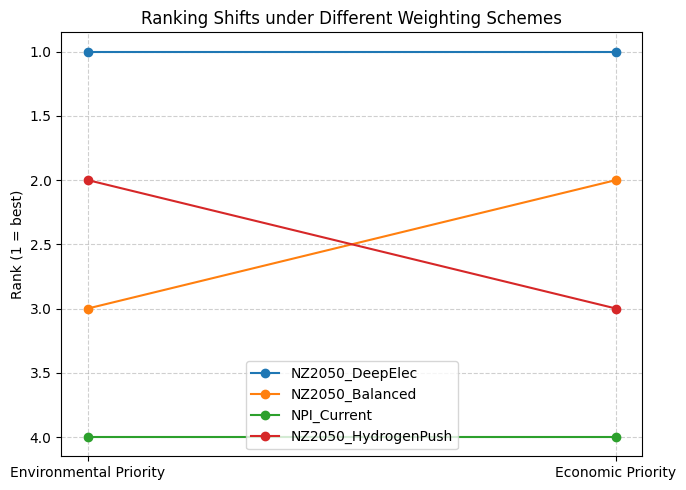

In [9]:

# Visualize ranking shifts between the two weighting schemes
plt.figure(figsize=(7,5))
for i, row in compare_df.iterrows():
    plt.plot(["Environmental Priority", "Economic Priority"],
             [row["Rank_Env"], row["Rank_Econ"]],
             marker="o", label=row["Alternative"])
plt.gca().invert_yaxis()
plt.title("Ranking Shifts under Different Weighting Schemes")
plt.ylabel("Rank (1 = best)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
# ΔRank Sensitivity Summary
# Calculate how much each alternative's rank changes between the two weighting schemes
compare_df["Rank_Change_(abs)"] = (compare_df["Rank_Env"] - compare_df["Rank_Econ"]).abs()
compare_df_sorted = compare_df.sort_values("Rank_Change_(abs)", ascending=False)

print("Ranking sensitivity between Environmental and Economic priority weightings:")
display(compare_df_sorted[["Alternative", "Rank_Env", "Rank_Econ", "Rank_Change_(abs)"]])

Ranking sensitivity between Environmental and Economic priority weightings:


,Alternative,Rank_Env,Rank_Econ,Rank_Change_(abs)
1,NZ2050_Balanced,3,2,1
3,NZ2050_HydrogenPush,2,3,1
0,NZ2050_DeepElec,1,1,0
2,NPI_Current,4,4,0



> **How to interpret ΔRank**
>
> - A **high ΔRank** means the option is sensitive to stakeholder priorities. It performs well only under specific value systems.
> - A **low ΔRank** means the option is robust. It ranks consistently across different perspectives.
> - In your report, discuss whether your recommended alternative is *robust* or *priority-dependent*, and what this implies for policymaking and public dialogue.



> **Interpretation:**
> - Large ranking shifts indicate sensitivity to priorities, meaning policies may be preferred only under certain value systems.
> - Stable rankings suggest robust options that perform well across stakeholder perspectives.
> - You are encuraged to discuss which weighting scenario reflects your country's policy stance or public opinion.

---

## Interpreting your MCA results for scenario-level analysis

Now that you have your aggregate MCA scores, use this section to interpret and discuss the results **as a policy analyst advising decision-makers**.

### Understanding the ranking
The `MCA_WeightedSum_0to100` column represents the **overall performance index** for each alternative (0–100 scale, 100 = best).  
Higher scores indicate stronger overall performance **given your chosen criteria and weights**.

- **Top-ranked alternative(s):** indicate the most desirable policy option(s) under your assumptions.  
- **Lower-ranked alternatives:** may perform poorly on key criteria (e.g., emissions, cost, or social acceptance).




### Reflecting on trade-offs
Explain **why** your highest-ranked alternative performs well.  
- Which criteria drive its high score (e.g., low emissions, high renewables, job creation)?  
- Which criteria does it perform less well on (e.g., higher cost, slower implementation)?  

Similarly, note where lower-ranked options might still have advantages. For example, lower costs or easier institutional feasibility.



### Considering robustness
Ask yourself:
- Would the ranking change if you shifted weights (economic vs. environmental priorities)?  
- Which alternatives are robust (perform well under different priorities)?  
- Which are sensitive (rank changes drastically when weights shift)?

Use the **ΔRank Sensitivity Summary** and plots above to support your reflection.

### Policy relevance
End with a short, evidence-based statement for policymakers:

Remember:  The MCA doesn’t deliver *the answer*. It structures transparent, evidence-based reasoning about complex trade-offs.


---

## Interpreting MCA results for technology-level analysis

In this version of the MCA, your **alternatives** represent *power generating technologies* (e.g., Solar PV, Onshore Wind, Gas + CCS, Nuclear).  

Your results show how each technology performs across technical, economic, environmental, social, and institutional criteria.

---

### Understanding the ranking
The `MCA_WeightedSum_0to100` score indicates the overall desirability of each technology within your chosen weighting scheme (0–100 = best).

- High-scoring technologies balance low emissions, reasonable costs, social acceptability, and feasibility.  
- Lower-scoring ones may perform well in one dimension (e.g., cheap or reliable) but poorly in others (e.g., emissions, acceptance, or institutional readiness).



### Reflecting on context and trade-offs
Discuss country-specific or regional factors that might influence interpretation:
- Physical/geographical constraints (e.g., limited land or offshore area).  
- System integration challenges (e.g., grid flexibility, intermittency).  
- Social and institutional acceptance (e.g., opposition to nuclear or onshore wind).  
- Resource availability (e.g., sunlight, wind, biomass, geological storage).

### Broader implications for the power mix
MCA results should not be read as “pick one technology.”  
Instead, interpret rankings as guidance on **which technologies should play stronger or weaker roles** in the future energy mix.

- High-ranking technologies → key pillars in the transition.  
- Mid-ranking → supporting roles or niche solutions.  
- Low-ranking → potential phase-out or require major innovation.

### Linking to national and EU strategies
Relate your conclusions to:
- National policy targets (e.g., NDCs, NECPs).  
- EU-level frameworks (e.g., Fit for 55, REPowerEU, Green Deal).  
- SDGs (especially SDG 7: Affordable & Clean Energy; SDG 13: Climate Action).

Your MCA results offer a transparent, evidence-based ranking of technologies, but always interpret them in light of national context, modelling assumptions, and social factors.
